#Chapter 1: Scraping OsloBors stock data

In this chapter we get our first data set from the OsloBors, Scandinavia's only independent stock exchange. 

#####The Imports
Most of the hard work in this chapter and the following chapters is done using Pandas, Pythons "library providing high-performance, easy-to-use data structures and data analysis tools". 

In [2]:
import urllib2
import StringIO
import pandas as pd
from pandas import read_html
import pymongo
from pymongo import MongoClient
import json
from datetime import datetime
from pandas.io.data import DataReader
import numpy as np

In [3]:
#For visulisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [4]:
#From python 3, dont have to worry about divide with floating numbers
from __future__ import division 

#####MongoDB: Where to save the data?
When we scrape stock information we want we do not want to have to rescrape it everytime we do some analysis. There are a number of methods to save the data, JSON, CSV, MYSQL, Python Pickle file, but I have decided to use MongoDB. 

MongoDB is a NoSQL database that stores information as Key:document pairs. Unlike a CSV file or equivalent, you can run powerful queries agasint MongoDB and make updates without loading and re-saving the entire file everytime.

In [4]:
#Setup MongoDB
#Switch on my file server then run in bash: mongod --dbpath /Volumes/Data/David_Files/data/db/
client = MongoClient()
db = client.oslo_bors #This is our database name
collectionStocks = db.stocks #stocks is our table (Collection) within the database

#####Creating a list of tickers
The first thing we need to know is a list of stock tickers, which we want to scrape data from. The OsloBors provides a list of all active stocks and their tickers in the form of a html table which we can get by following a given url. However, this html table is loaded via javascript, this means we cannot simply extract the html table using an html parser. The reason is because most html parsers, like beautiful soup, typically do not render javascript code. So we us a library selenium to open the url in the firefox browser, which does render javascript code. Then we extract the html from the broswer and use pandas to get extract our table and therefore our ticket list. 

The end result should look something like this.

tickers = ['ASC', 'AFG',...,'ZONC']

In [5]:
#Load the webpage in firefox and extract the content
from selenium import webdriver
browser = webdriver.Firefox()
browser.get('http://www.oslobors.no/markedsaktivitet/#/list/shares/quotelist/ob/all/false')
content = browser.page_source
browser.quit()

#Save the list of tickers
stocks = pd.read_html(content)[0]
tickers = stocks['Ticker'].tolist()

#####The link to stock data
The following links leads to statoils (STL) excel sheet containing 5 years worth of stock data. We use this link, replacing STL with each ticker in our ticker list to extract data for all our stocks.

In [18]:
#The link for the statoil stock excel 5 years
link = 'http://www.oslobors.no/ob/servlets/excel?type=history&columns=DATE%2C+CLOSE_CA%2C+BID_CA%2C+ASK_CA%2C+HIGH_CA%2C+LOW_CA%2C+TURNOVER_TOTAL%2C+VOLUME_TOTAL_CA%2C+TRADES_COUNT%2C+TRADES_COUNT_TOTAL%2C+VWAP&format[DATE]=ddd.mm.YY&format[CLOSE_CA]=%23%2C%23%230.00%23%23%23&format[BID_CA]=%23%2C%23%230.00%23%23&format[ASK_CA]=%23%2C%23%230.00%23%23&format[HIGH_CA]=%23%2C%23%230.00%23%23%23&format[LOW_CA]=%23%2C%23%230.00%23%23%23&format[TURNOVER_TOTAL]=%23%2C%23%230&format[VOLUME_TOTAL_CA]=%23%2C%23%230&format[TRADES_COUNT]=%23%2C%23%230&format[TRADES_COUNT_TOTAL]=%23%2C%23%230&format[VWAP]=%23%2C%23%230.00%23%23%23&header[DATE]=STL&header[CLOSE_CA]=Last&header[BID_CA]=Bid&header[ASK_CA]=Ask&header[HIGH_CA]=High&header[LOW_CA]=Low&header[TURNOVER_TOTAL]=Total%20turnover%20%28NOK%29&header[VOLUME_TOTAL_CA]=Total%20amount%20shares%20volume&header[TRADES_COUNT]=Amount%20off.%20trades&header[TRADES_COUNT_TOTAL]=Amount%20trades%20total&header[VWAP]=VWAP&view=DELAYED&source=feed.ose.quotes.INSTRUMENTS&filter=ITEM_SECTOR%3D%3DsSTL.OSE%26%26DELETED!%3Dn1&stop=now&start=1286402400000&space=DAY&ascending=true&limit=10000000&filename=data.xlsx'

#####Downloading the stock data
The following code simply runs a loop over all the tickers in our ticker list, puts them in the statoil URL link and downloads the excel file as a pandas dataframe.

In [20]:
collectionStocks.remove() #Remove the old data from the MongoDB database

for i in tickers:
    
    print str(i) + " - Scraping"
    
    #Extract the Data from the excel
    ticker = str(i).replace(" ","%20") #Some tickers have spaces in their names ('SAS NOK'), so we replace the space with a %20 to not break the URL
    url = link.replace("STL", ticker) #Swap out statoils ticker for the one in our list
    xld = urllib2.urlopen(url).read()
    xlds = StringIO.StringIO(xld)
    data = pd.read_excel(xlds, "data") #Turn the excel file into a pandas dataframe
    
    data.columns = data.columns.str.replace('.','') #The column names are keys in mongoDB and mongoDB doesnt like '.' in its key names
    
    data.rename(columns = {str(i):'Date'}, inplace=True) #Name the date column to date, it is orginally called after the ticker
    
    data['Ticker'] = str(i) #Add a ticker column
    
    records = json.loads(data.T.to_json(date_format='iso')).values() #Convert dataframe to json, which is a format that can be directly loaded into mongoDB
    
    #Here we check for any errors before saving the data to mongoDB
    if len(records) > 0:
        collectionStocks.insert(records) #Store the data in the mongoDB
        
        print str(i) + " - Added to the database" #Current stock we are scraping
    else:
        print str(i) + " - Not scraped, see comment" #some tickers use OAX and not OSE in its link string, so our statoil link returns empty for these tickers. For now we just ignore them
        

ASC - Scraping
ASC - Added to the database
AFG - Scraping
AFG - Added to the database


#####Test if our data saved correctly
Just to make sure mongoDB was working as I thought it should, I extract a signle row from the database and load it into a pandas dataframe.

In [53]:
test_data = collectionStocks.find_one() #Find a single value in our mongoDB database and check it isn't empty
test = pd.DataFrame.from_dict([test_data]) #Load that data into a pandas dataframe
#print test.columns.values[2].encode(encoding='latin-1')

#####Finished
We now have 5 years of OsloBors data for most of our ticker list saved into our database. The next step is to get a basic understanding of our data by doing some stock analysis.

###Data Analysis Part

In [5]:
#My data analysis will be from today till 1 year ago
end = datetime.now()
start = datetime(end.year-1,end.month,end.day)

In [6]:
scraped_tickers = collection.distinct("Ticker")

In [25]:
table_list = []
for i in scraped_tickers:
    cursor = collection.find({"Ticker": i})
    temp_frame = pd.DataFrame(list(cursor))
    
    #Do some dataframe setup, turn Date back into datetime and make it the index
    temp_frame['Date'] = pd.to_datetime(temp_frame['Date'])
    temp_frame = temp_frame.set_index(['Date'])
    temp_frame = temp_frame.sort_index()
    temp_frame = temp_frame.ix[start:end] #Set the the desired date range here
    
    globals()[i] = temp_frame
    
    temp_join_list = temp_frame.copy()
    
    #Setup multiindex
    arrays = [np.array([i, i, i, i, i, i, i, i, i, i, i, i]),
          np.array(['Amount off trades', 'Amount trades total', 'Ask', 'Bid', 'High', 'Last','Low', 'Ticker', 'Total amount shares volume','Total turnover (NOK)','VWAP','_id'])]
    index = pd.MultiIndex.from_arrays(arrays)
    temp_join_list.columns = index
    
    table_list.append(temp_join_list)

In [27]:
joined_table = pd.concat(table_list, axis=1)

In [26]:
EVRY.describe()

,Amount off trades,Amount trades total,Ask,Bid,High,Last,Low,Total amount shares volume,Total turnover (NOK),VWAP
count,224.000000,224.000000,247.000000,247.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000
mean,15.343750,15.424107,16.147571,15.909109,16.076563,15.955580,15.841295,118682.383929,1890155.258929,15.938613
std,17.485745,17.589580,1.075888,1.044171,1.088329,1.064786,1.004989,550572.354710,8702905.058637,1.022929
min,1.000000,1.000000,14.050000,14.000000,14.000000,14.000000,13.200000,1.000000,14.500000,14.000000
25%,2.000000,2.000000,15.500000,15.300000,15.400000,15.300000,15.300000,995.750000,15429.075000,15.300000
50%,10.000000,10.000000,16.000000,15.900000,16.000000,15.900000,15.900000,10156.000000,167854.600000,15.903600
75%,22.000000,22.250000,17.200000,17.000000,17.125000,17.000000,16.800000,34486.000000,571920.950000,17.000000
max,104.000000,106.000000,21.000000,20.000000,20.000000,20.000000,17.700000,5538046.000000,86951346.700000,18.194300


In [28]:
EVRY.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2014-10-13 to 2015-10-07
Data columns (total 12 columns):
Amount off trades             224 non-null float64
Amount trades total           224 non-null float64
Ask                           247 non-null float64
Bid                           247 non-null float64
High                          224 non-null float64
Last                          224 non-null float64
Low                           224 non-null float64
Ticker                        247 non-null object
Total amount shares volume    224 non-null float64
Total turnover (NOK)          224 non-null float64
VWAP                          224 non-null float64
_id                           247 non-null object
dtypes: float64(10), object(2)
memory usage: 25.1+ KB


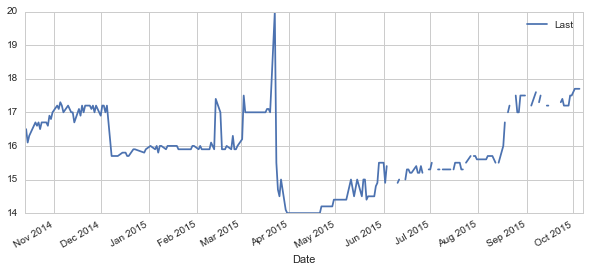

In [29]:
EVRY['Last'].plot(legend=True, figsize=(10,4))

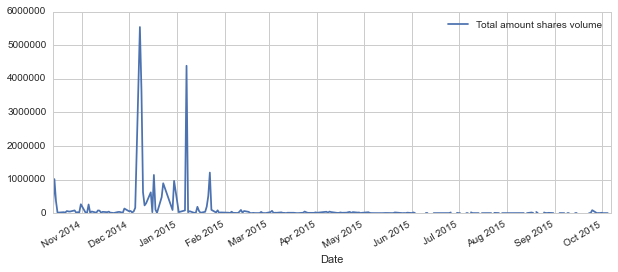

In [30]:
EVRY['Total amount shares volume'].plot(legend=True, figsize=(10,4))

In [29]:
ma_day = [10, 20, 50] #Number of days for moving average

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    
    EVRY[column_name] = pd.rolling_mean(EVRY['Last'],ma)

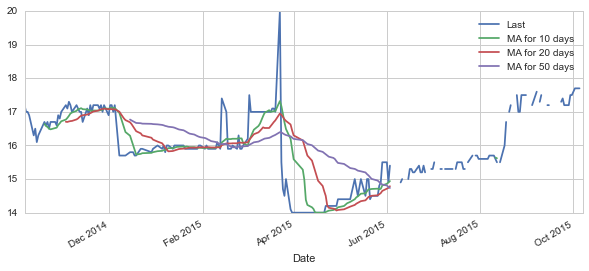

In [30]:
EVRY[['Last',"MA for 10 days","MA for 20 days","MA for 50 days" ]].plot(subplots=False, figsize=(10,4))

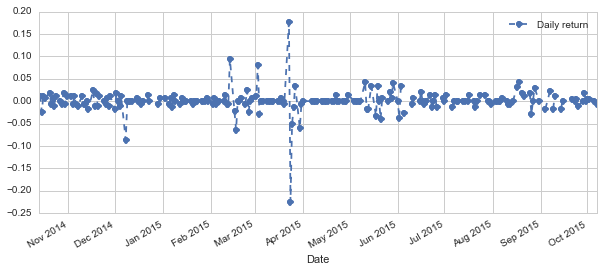

In [33]:
#EVRY['Daily return'] = EVRY['Last'] / EVRY['Last'].shift(1) - 1
EVRY['Daily return'] = EVRY['Last'].pct_change()
DNB['Daily return'] = DNB['Last'].pct_change()
EVRY['Daily return'].plot(legend=True, figsize=(10,4), linestyle='--',marker='o')

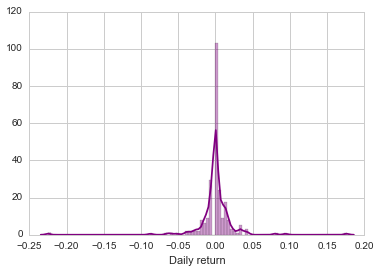

In [47]:
sns.distplot(EVRY['Daily return'].dropna(),bins=100,color='purple')

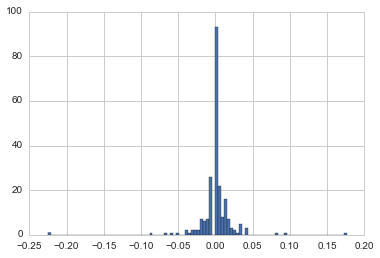

In [32]:
EVRY['Daily return'].hist(bins=100)

In [8]:
yahoo_tickers = [x.replace(" ", "-") +".OL" for x in scraped_tickers] #Convert to the names to yahoo tickers
closing_df = DataReader(yahoo_tickers,'yahoo',start,end)['Adj Close']

In [9]:
oslo_returns = closing_df.pct_change()

In [72]:
oslo_returns.tail()

,AFG.OL,AFK.OL,AGA.OL,AKA.OL,AKER.OL,AKSO.OL,AKVA.OL,AMSC.OL,APP.OL,AQUA.OL,...,WBULK.OL,WEIFA.OL,WILS.OL,WRL.OL,WWASA.OL,WWI.OL,WWIB.OL,XXL.OL,YAR.OL,ZAL.OL
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-30,0.000000,0.009615,0.035897,-0.004525,0.010239,-0.017356,0.000000,0.010101,0.238318,0.017544,...,0.059041,0.015873,-0.096234,-0.004988,0.002740,0.010490,0.007092,-0.005988,0.008616,0.008475
2015-10-01,0.009091,0.000000,-0.029703,-0.009091,0.037162,0.036005,0.000000,0.000000,0.000000,-0.051724,...,0.000000,-0.031250,0.000000,-0.002506,0.002732,-0.010381,-0.003521,0.012048,0.005596,0.016807
2015-10-02,0.009009,-0.016667,0.020408,-0.018349,0.026059,0.032459,0.000000,-0.032500,-0.037736,0.060606,...,0.000000,0.016129,0.000000,0.000000,-0.019074,0.006993,-0.014134,0.002976,-0.005565,-0.002755
2015-10-05,0.004464,0.012107,-0.010000,0.046729,0.044444,0.067005,0.035211,0.010336,0.000000,0.021429,...,0.000000,0.015873,0.000000,0.000000,0.027778,0.000000,0.014337,-0.002967,0.013549,0.027624
2015-10-06,0.022222,0.000000,0.000000,NaN,0.042553,0.024405,-0.013605,-0.066496,0.058824,0.000000,...,0.000000,0.000000,0.000000,0.012563,0.000000,0.010417,0.000000,0.000000,0.017146,-0.010753


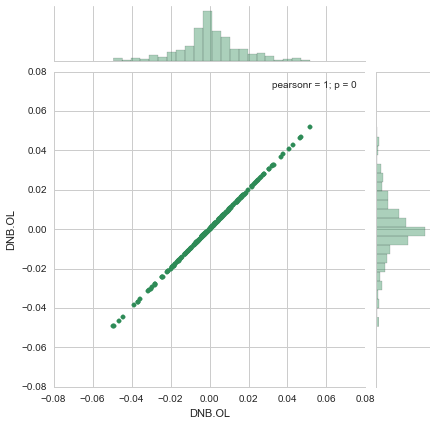

In [73]:
sns.jointplot('DNB.OL','DNB.OL',oslo_returns,kind='scatter',color='seagreen')

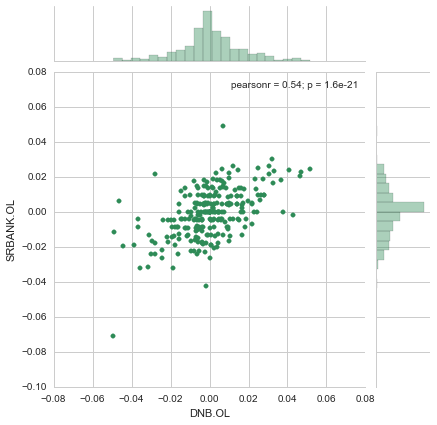

In [75]:
sns.jointplot('DNB.OL','SRBANK.OL',oslo_returns,kind='scatter',color='seagreen')

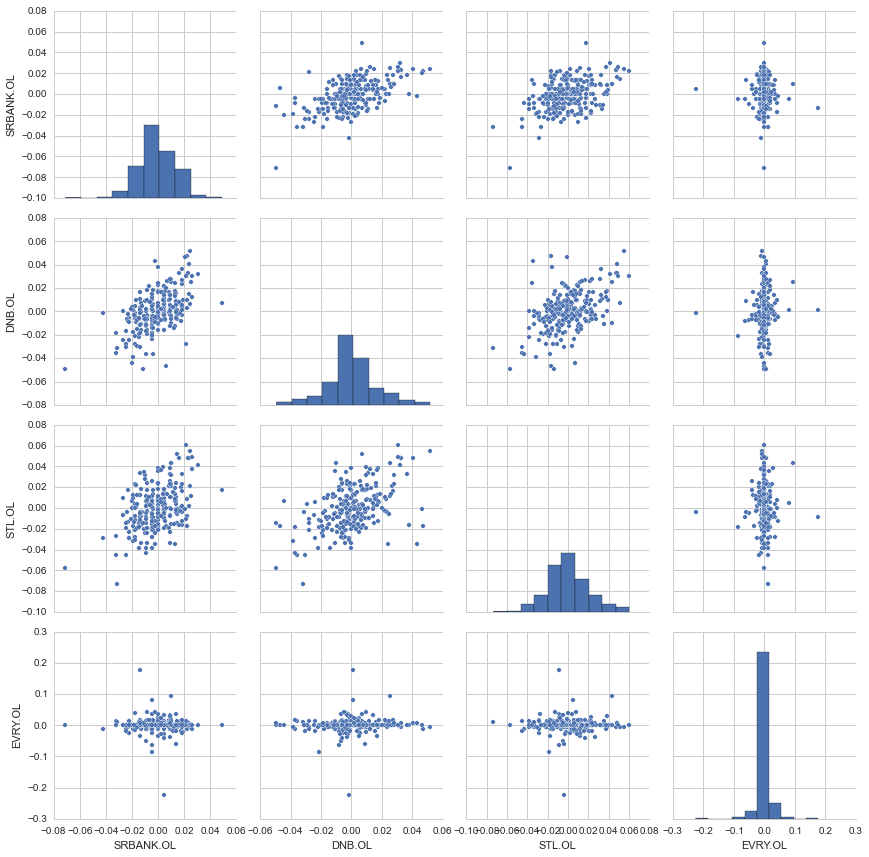

In [86]:
sns.pairplot(oslo_returns[['SRBANK.OL','DNB.OL','STL.OL','EVRY.OL']].dropna())

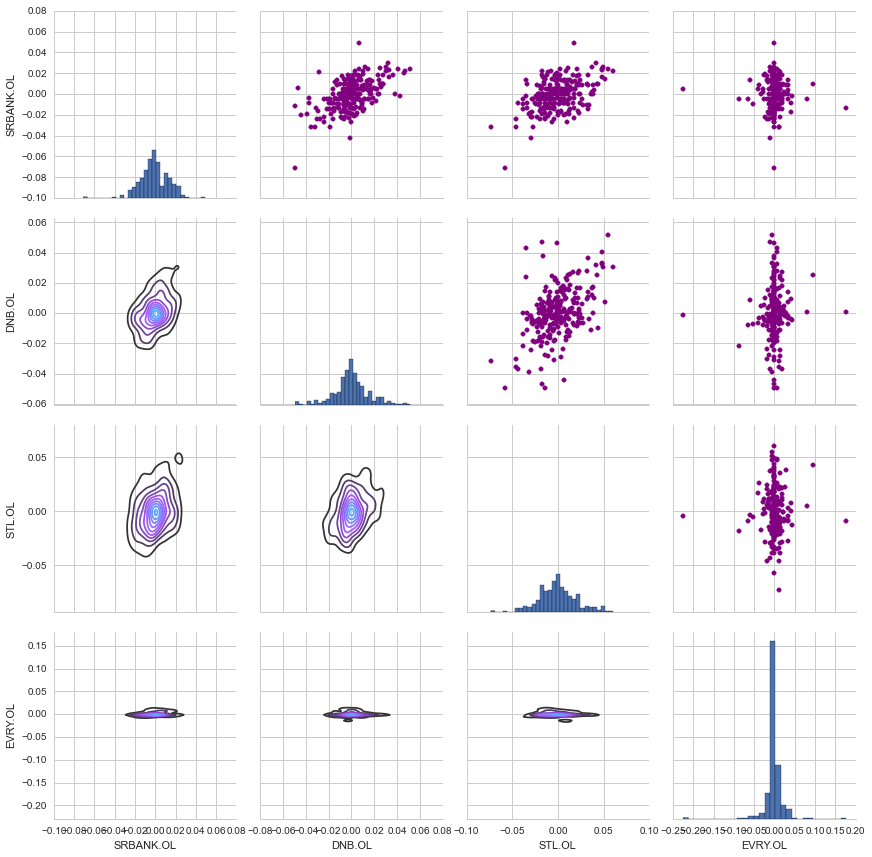

In [106]:
returns_fig = sns.PairGrid(oslo_returns[['SRBANK.OL','DNB.OL','STL.OL','EVRY.OL']].dropna())

returns_fig.map_upper(plt.scatter,color='purple')
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(plt.hist,bins=30)

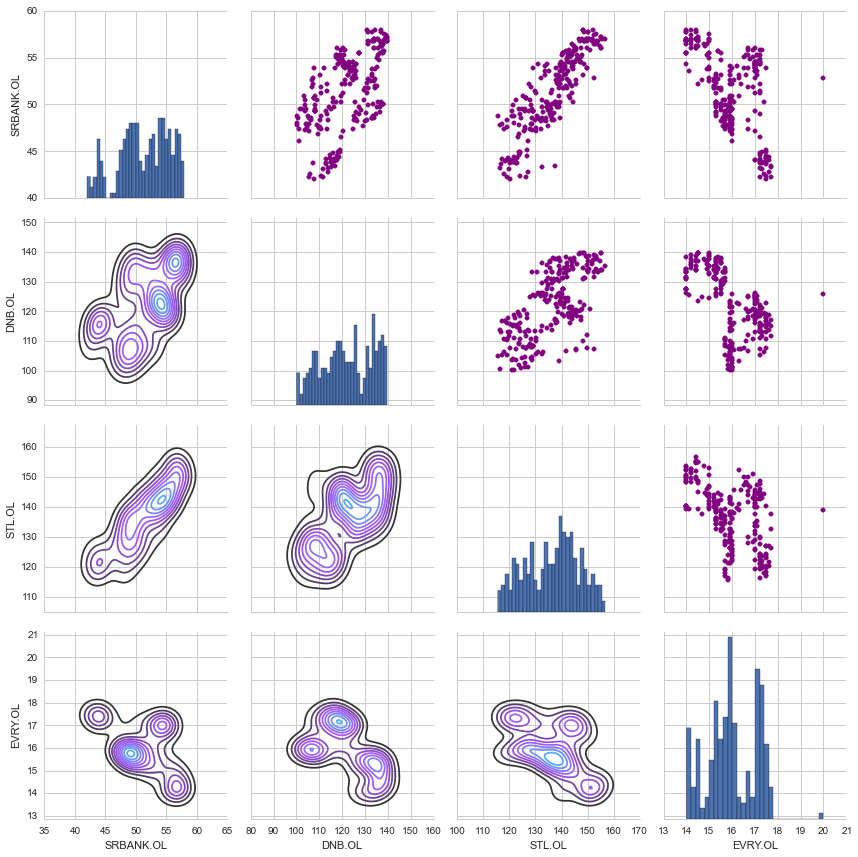

In [107]:
returns_fig = sns.PairGrid(closing_df[['SRBANK.OL','DNB.OL','STL.OL','EVRY.OL']].dropna())

returns_fig.map_upper(plt.scatter,color='purple')
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(plt.hist,bins=30)

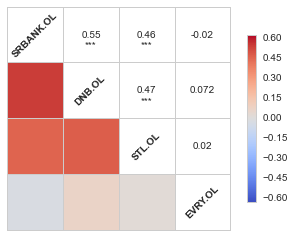

In [108]:
sns.corrplot(oslo_returns[['SRBANK.OL','DNB.OL','STL.OL','EVRY.OL']].dropna(),annot=True)

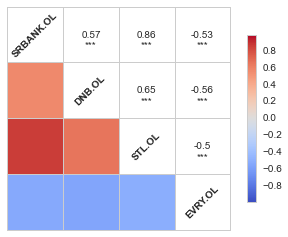

In [109]:
sns.corrplot(closing_df[['SRBANK.OL','DNB.OL','STL.OL','EVRY.OL']].dropna(),annot=True)

###Risk Analysis

In [10]:
rets = oslo_returns[['SRBANK.OL','DNB.OL','STL.OL','EVRY.OL']].dropna()

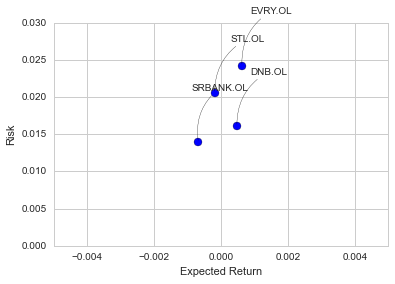

In [12]:
area = np.pi*20

plt.scatter(rets.mean(),rets.std(), s=area)

plt.xlim(-0.005,0.005)
plt.ylim(0,0.03)

plt.xlabel('Expected Return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label,
    xy = (x, y), xytext = (50, 50),
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3, rad=0.3'))

In [22]:
rets.std()

SRBANK.OL    0.013915
DNB.OL       0.016090
STL.OL       0.020521
EVRY.OL      0.024218
dtype: float64

In [14]:
rets.head()

,SRBANK.OL,DNB.OL,STL.OL,EVRY.OL
Date,,,,
2014-10-14,0.018265,0.003633,-0.016858,0.012270
2014-10-15,-0.022420,-0.005429,-0.028570,-0.024242
2014-10-16,-0.032111,-0.035487,-0.045751,0.012422
2014-10-17,0.023695,0.040567,0.047944,0.006135
2014-10-20,-0.004629,-0.006347,-0.028106,0.018293


###Value at risk

####Bootstrap method

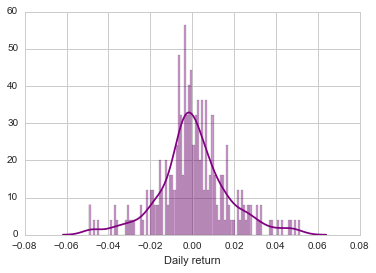

In [37]:
sns.distplot(DNB['Daily return'].dropna(),bins=100,color='purple')

In [38]:
rets.head()

,SRBANK.OL,DNB.OL,STL.OL,EVRY.OL
Date,,,,
2014-10-14,0.018265,0.003633,-0.016858,0.012270
2014-10-15,-0.022420,-0.005429,-0.028570,-0.024242
2014-10-16,-0.032111,-0.035487,-0.045751,0.012422
2014-10-17,0.023695,0.040567,0.047944,0.006135
2014-10-20,-0.004629,-0.006347,-0.028106,0.018293


In [40]:
rets['DNB.OL'].quantile(0.05)

-0.02789785178631804

In [6]:
tickers

[u'ASC',
 u'AFG',
 u'APCL',
 u'ZONC']